# Do XGB CV using Precision Recall AUC rather than ROC AUC. Find very small difference in performance

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import dill
import sys
sys.path.append('../')
from modelfitting import train_test_split, ROC_curve, PR_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction

In [2]:
datapath = '/mnt/ssd/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
featurefolder = 'ressummaryfeaturesxgbNorbits10000.0Nout1000/'
features = None

In [3]:
trainingdatafolder = datapath+dset+featurefolder
trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features)

In [13]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "aucpr", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-aucpr-mean"])
    error = np.mean(score["test-aucpr-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

In [14]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.8213935400000001                                  
ERROR                                               
0.022770968229508016                                
HOLDOUT SCORE                                       
0.9284137238534219                                  
SCORE:                                                                        
0.82254434                                                                    
ERROR                                                                         
0.02299394994593714                                                           
HOLDOUT SCORE                                                                 
0.9286163636143674                                                            
SCORE:                                                                        
0.8211744800000002                                                            
ERROR                                             

0.015654399178747964                                                           
HOLDOUT SCORE                                                                  
0.9285276457090779                                                             
SCORE:                                                                         
0.81791258                                                                     
ERROR                                                                          
0.020544314263914874                                                           
HOLDOUT SCORE                                                                  
0.9239959754332056                                                             
SCORE:                                                                         
0.82805436                                                                     
ERROR                                                                          
0.018443639642826533                    

0.013965080284767426                                                           
HOLDOUT SCORE                                                                  
0.5                                                                            
SCORE:                                                                         
0.82159232                                                                     
ERROR                                                                          
0.018359022200164145                                                           
HOLDOUT SCORE                                                                  
0.9292928376422008                                                             
SCORE:                                                                         
0.8170441800000001                                                             
ERROR                                                                          
0.01859020662103253                     

In [15]:
best

{'x_learning_rate': 0.07692134413455207,
 'x_max_depth': 11,
 'x_min_child': 4.0,
 'x_pos_weight': 12.008614249447442,
 'x_subsample': 0.8287309108835599,
 'x_tree_colsample': 0.75557830389685}

In [16]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "aucpr", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-aucpr:0.780762+0.01327	test-aucpr:0.70963+0.019693
[1]	train-aucpr:0.844198+0.0186128	test-aucpr:0.761694+0.0215451
[2]	train-aucpr:0.867641+0.0177491	test-aucpr:0.787073+0.0297586
[3]	train-aucpr:0.88123+0.0121354	test-aucpr:0.800127+0.0277582
[4]	train-aucpr:0.889669+0.0114498	test-aucpr:0.805709+0.0289936
[5]	train-aucpr:0.897406+0.0121715	test-aucpr:0.805339+0.0284229
[6]	train-aucpr:0.908529+0.00637986	test-aucpr:0.810464+0.0299124
[7]	train-aucpr:0.912606+0.00683199	test-aucpr:0.815702+0.0252218
[8]	train-aucpr:0.920397+0.00594255	test-aucpr:0.817327+0.0241993
[9]	train-aucpr:0.925151+0.0064168	test-aucpr:0.820412+0.0244699
   train-aucpr-mean  train-aucpr-std  test-aucpr-mean  test-aucpr-std
0          0.780762         0.013270         0.709630        0.019693
1          0.844198         0.018613         0.761694        0.021545
2          0.867641         0.017749         0.787073        0.029759
3          0.881230         0.012135         0.800127        0.027758
4 

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.8276235717719186


In [17]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75557830389685, gamma=0,
       learning_rate=0.07692134413455207, max_delta_step=0, max_depth=11,
       min_child_weight=4.0, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=12.008614249447442,
       seed=None, silent=True, subsample=0.8287309108835599)

Text(0.5, 1.0, 'ROC curve (AUC = 0.943)')

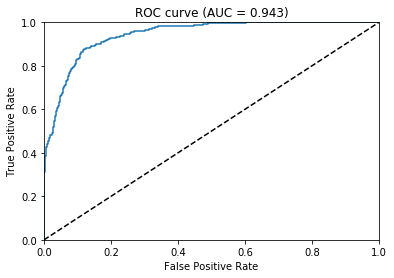

In [18]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [21]:
pr_auc, precision, recall, PRthresholds = PR_curve(trainingdatafolder, model, features)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(PRthresholds[i], recall[i], precision[i]))

Threshold 0.008735956624150276, recall = 1.0, precision = 0.4214801444043321
Threshold 0.009356862865388393, recall = 0.9978586723768736, precision = 0.4263494967978042
Threshold 0.00990913063287735, recall = 0.9978586723768736, precision = 0.4322820037105751
Threshold 0.01118516456335783, recall = 0.9978586723768736, precision = 0.43838193791157104
Threshold 0.012281272560358047, recall = 0.9978586723768736, precision = 0.4446564885496183
Threshold 0.013150620274245739, recall = 0.9978586723768736, precision = 0.45111326234269117
Threshold 0.014322025701403618, recall = 0.9978586723768736, precision = 0.4577603143418468
Threshold 0.015855329111218452, recall = 0.9978586723768736, precision = 0.4646061814556331
Threshold 0.016817398369312286, recall = 0.9978586723768736, precision = 0.4716599190283401
Threshold 0.01799878105521202, recall = 0.9914346895074947, precision = 0.47584789311408016
Threshold 0.020118599757552147, recall = 0.9892933618843683, precision = 0.4822546972860125
Thr

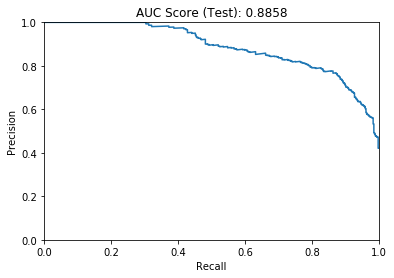

In [22]:
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title("AUC Score (Test): {0:.4f}".format(pr_auc))
plt.show()

(0, 91.30000000000001)

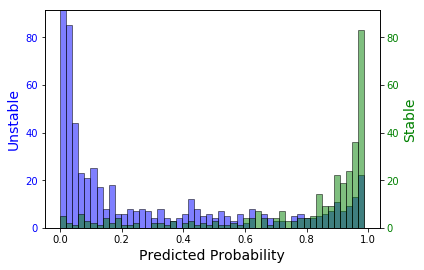

In [23]:
# Histogram:
bins = 50
Stable, Unstable = stable_unstable_hist(trainingdatafolder, model, features)

fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
#print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
#print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,1.1*n[-1]]) # goes up to ~4300
ax2.set_ylim([0,1.1*n[-1]]) # goes up to ~2100

Text(0, 0.5, 'Fraction actually stable')

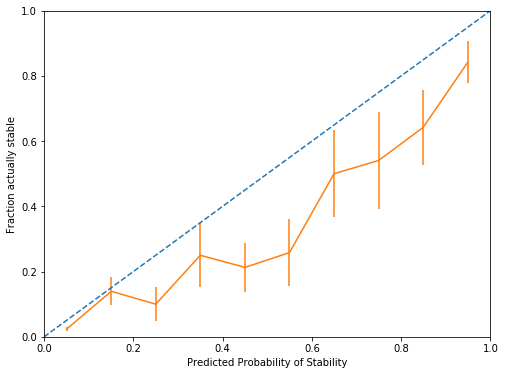

In [24]:
bincenters, fracstable, errorbars = calibration_plot(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')
ax.errorbar(bincenters, fracstable, errorbars)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_xlabel('Predicted Probability of Stability')
ax.set_ylabel('Fraction actually stable')

Text(0.5, 1.0, 'Fraction of unstable systems mislabeled as stable')

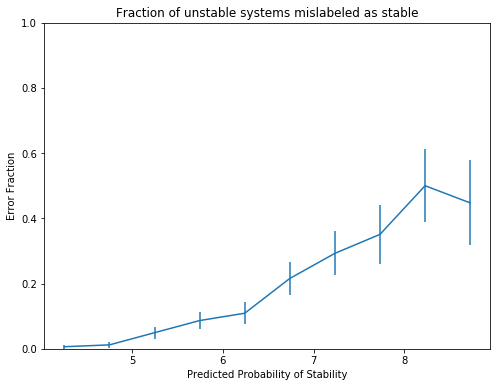

In [25]:
bincenters, errorfracs, errorbars = unstable_error_fraction(trainingdatafolder, model, features, bins=10)
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bincenters, errorfracs, errorbars)
ax.set_ylim([0,1])
ax.set_xlabel('Log Instability Time')
ax.set_ylabel('Error Fraction')
ax.set_title('Fraction of unstable systems mislabeled as stable')

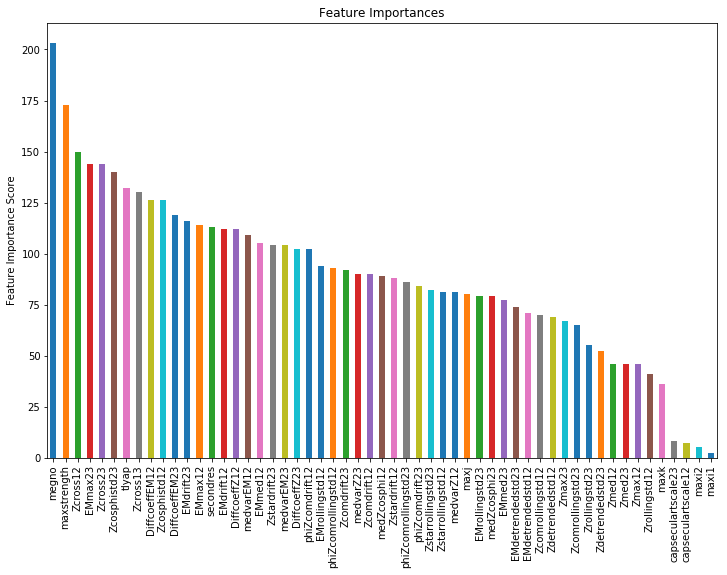

In [14]:
# feature importances
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [26]:
dill.dump([model, features, featurefolder], open(datapath+"../models/ressummaryfeaturesxgb_resonantPRCV.pkl", "wb"))